Using device: cpu
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!
Processed data saved as X.pt and y.pt in current directory.
Loaded X: 4320 samples, Loaded y: 4320 labels
x_train shape: (2764, 180), y_train shape: (2764,)
x_val shape: (692, 180), y_val shape: (692,)
x_test shape: (864, 180), y_test shape: (864,)
Label mapping: {np.str_('angry'): np.int64(0), np.str_('calm'): np.int64(1), np.str_('disgust'): np.int64(2), np.str_('fearful'): np.int64(3), np.str_('happy'): np.int64(4), np.str_('neutral'): np.int64(5), np.str_('sad'): np.int64(6), np.str_('surprised'): np.int64(7)}
Features extracted: 180
HighAccuracyMLP(
  (fc1): Linear(in_features=180, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=2048, out_fea

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/200], Train Loss: 14.4770, Train Acc: 16.24%, Val Loss: 7.3105, Val Acc: 19.08%
Validation accuracy improved. Saving model.
Epoch [2/200], Train Loss: 4.0812, Train Acc: 24.89%, Val Loss: 3.3595, Val Acc: 22.54%
Validation accuracy improved. Saving model.
Epoch [3/200], Train Loss: 2.6758, Train Acc: 28.04%, Val Loss: 1.9765, Val Acc: 32.51%
Validation accuracy improved. Saving model.
Epoch [4/200], Train Loss: 2.2832, Train Acc: 31.91%, Val Loss: 2.0714, Val Acc: 34.54%
Validation accuracy improved. Saving model.
Epoch [5/200], Train Loss: 2.0616, Train Acc: 35.78%, Val Loss: 2.0070, Val Acc: 38.15%
Validation accuracy improved. Saving model.
Epoch [6/200], Train Loss: 1.9018, Train Acc: 37.92%, Val Loss: 1.7809, Val Acc: 41.47%
Validation accuracy improved. Saving model.
Epoch [7/200], Train Loss: 1.7330, Train Acc: 41.21%, Val Loss: 1.6816, Val Acc: 41.47%
Validation accuracy did not improve for 1 epochs.
Epoch [8/200], Train Loss: 1.6035, Train Acc: 43.27%, Val Loss: 1.542

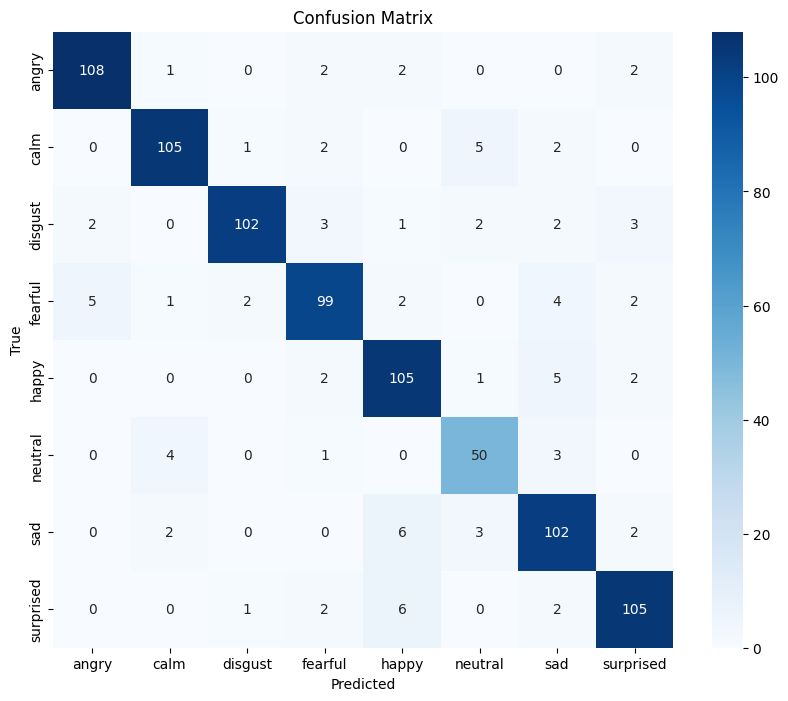


--- Saving Model Weights ---
Model weights saved to weights.txt

Saved original and padded weights for fc1.weight to Excel.
Saved original weights for fc1.bias to Excel (not a 2D linear layer weight).
Saved original weights for bn1.weight to Excel (not a 2D linear layer weight).
Saved original weights for bn1.bias to Excel (not a 2D linear layer weight).
Saved original and padded weights for fc2.weight to Excel.
Saved original weights for fc2.bias to Excel (not a 2D linear layer weight).
Saved original weights for bn2.weight to Excel (not a 2D linear layer weight).
Saved original weights for bn2.bias to Excel (not a 2D linear layer weight).
Saved original and padded weights for fc3.weight to Excel.
Saved original weights for fc3.bias to Excel (not a 2D linear layer weight).
Saved original weights for bn3.weight to Excel (not a 2D linear layer weight).
Saved original weights for bn3.bias to Excel (not a 2D linear layer weight).
Saved original and padded weights for fc4.weight to Excel.

In [ ]:
# --- Block 1: Imports and Google Drive Mounting ---
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os, glob, pickle
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F # Import for padding

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mount Google Drive
# This will prompt you to open a URL, authorize access, and paste an authorization code.
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")
except ImportError:
    print("Not running in Google Colab. Please ensure your dataset path is correct for your environment.")
    print("If running locally, you might need to adjust the data_directory variable.")

# Define the path to your dataset on Google Drive
# IMPORTANT: Replace 'Your_RAVDESS_Dataset_Folder/' with the actual path to your RAVDESS dataset
# within your Google Drive. For example, if your RAVDESS folder is directly in My Drive,
# it would be '/content/drive/MyDrive/RAVDESS/'.
# To find the correct path:
# 1. Go to the "Files" icon on the left sidebar in Colab.
# 2. Navigate to your dataset folder (e.g., drive -> MyDrive -> RAVDESS).
# 3. Right-click on the folder containing 'Actor_XX' subfolders and select "Copy path".
# 4. Paste that path here.
data_directory = '/content/drive/MyDrive/Datasets1/' # <<<--- CHANGE THIS PATH

# --- Block 2: Emotions Dictionary ---
# Emotions in the RAVDESS dataset, different numbers represent different emotion
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

# --- Block 3: Feature Extraction Function ---
def extract_feature(data, sr, mfcc=True, chroma=True, mel=True):
    """
    Extract features from audio files into a PyTorch tensor.

    Parameters
    ----------
    data : np.ndarray, audio time series
    sr : int, sampling rate
    mfcc : bool, Mel Frequency Cepstral Coefficient (MFCC)
    chroma : bool, Chroma feature
    mel : bool, Mel Spectrogram Frequency

    Returns
    -------
    torch.Tensor : Extracted features as a PyTorch tensor
    """

    result = []

    if chroma:
        stft = np.abs(librosa.stft(data))

    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result.append(mfccs)

    if chroma:
        chroma_feature = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
        result.append(chroma_feature)

    if mel:
        mel_feature = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
        result.append(mel_feature)

    # Convert to a PyTorch tensor
    result = np.hstack(result)
    return torch.tensor(result, dtype=torch.float32)

# --- Block 4: Add Noise Function ---
def add_noise(data, noise_factor):
    """
    Add random white noise to the audio.

    Parameters
    ----------
    data : torch.Tensor, audio time series
    noise_factor : float, the measure of noise to be added

    Returns
    -------
    torch.Tensor : Noisy audio data
    """
    noise = torch.randn_like(data)  # Generate random noise with the same shape as data
    augmented_data = data + noise_factor * noise

    return augmented_data

# --- Block 5: Shift Audio Function ---
def shift_audio(data, sampling_rate, shift_max, shift_direction):
    """
    Shift the audio in a given direction.

    Parameters
  ----------
    data : torch.Tensor, audio time series
    sampling_rate : int, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : str, 'right' or 'both'

    Returns
    -------
    torch.Tensor : Shifted audio data
    """
    shift = torch.randint(0, int(sampling_rate * shift_max), (1,)).item()

    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = torch.randint(0, 2, (1,)).item()
        if direction == 1:
            shift = -shift

    augmented_data = torch.roll(data, shifts=shift)

    # Zero-pad the shifted portion
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0

    return augmented_data

# --- Block 6: Load Data Function ---
def load_data(data_directory, emotions, save=False):
    """
    Load dataset and apply feature extraction & augmentation.

    Parameters
    ----------
    data_directory : str, path to dataset directory
    emotions : dict, mapping of emotion labels
    save : bool, whether to save the processed data

    Returns
    -------
    torch.Tensor : Feature tensor (X)
    list : Labels (y)
    """
    x, y = [], []

    # Use os.path.join for cross-platform compatibility and correct path construction
    # The glob pattern assumes the RAVDESS structure like 'Actor_01/01-01-01-01-01-01-01.wav'
    audio_files = glob.glob(os.path.join(data_directory, "Actor_*/*.wav"))

    if not audio_files:
        print(f"Warning: No audio files found in '{data_directory}' matching 'Actor_*/*.wav'.")
        print("Please check your 'data_directory' path and the dataset structure in Google Drive.")
        print("Ensure 'Actor_XX' subfolders containing '.wav' files are directly within the specified 'data_directory'.")
        return torch.empty(0), [] # Return empty tensors/lists if no files are found

    for file in audio_files:
        # Load an audio file as a floating point time series
        data, sr = librosa.load(file)

        # Extract features from the original audio
        feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
        x.append(feature)

        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]  # Extract emotion label
        y.append(emotion)

        # Apply data augmentation (noise)
        # Ensure data is converted to tensor before passing to add_noise
        n_data = add_noise(torch.tensor(data, dtype=torch.float32), 0.001)
        n_feature = extract_feature(n_data.numpy(), sr, mfcc=True, chroma=True, mel=True)
        x.append(n_feature)
        y.append(emotion)

        # Apply data augmentation (shifting)
        # Ensure data is converted to tensor before passing to shift_audio
        s_data = shift_audio(torch.tensor(data, dtype=torch.float32), sr, 0.25, 'right')
        s_feature = extract_feature(s_data.numpy(), sr, mfcc=True, chroma=True, mel=True)
        x.append(s_feature)
        y.append(emotion)

    # Convert to PyTorch tensor
    # Stack the list of tensors into a single tensor
    x = torch.stack(x)


    if save:
        # Save to current Colab environment, you can then move these to Drive if needed
        torch.save(x, 'X.pt')
        torch.save(y, 'y.pt')
        print("Processed data saved as X.pt and y.pt in current directory.")

    return x, y

# --- Block 7: Data Loading and Train-Validation-Test Split Execution ---
# Load the dataset with correct parameters
X, y = load_data(data_directory, emotions, save=True)

# Check if X and y are populated
print(f"Loaded X: {len(X)} samples, Loaded y: {len(y)} labels")

# Ensure that the data isn't empty
if len(X) == 0 or len(y) == 0:
    raise ValueError("No data loaded. Check the dataset path and ensure the `load_data` function works correctly.")

# Convert to numpy arrays for sklearn splitting
X_np = X.numpy()
y_np = np.array(y)

# First split: Separate out the test set (20%)
x_train_val, x_test, y_train_val, y_test = train_test_split(X_np, y_np, test_size=0.20, random_state=9, stratify=y_np)

# Second split: Separate training and validation from the remaining data (e.g., 80% of remaining for train, 20% for val)
# This results in: ~64% train, ~16% validation, 20% test
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.20, random_state=9, stratify=y_train_val)


# Print the shapes of the resulting sets
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# --- Block 8: Label Encoding ---
# Initialize the LabelEncoder
labelencoder = LabelEncoder()

# Fit and transform labels
labelencoder.fit(y_train) # Fit on training labels only

# Get mapping of labels to encoded values
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(f"Label mapping: {le_name_mapping}")

# Convert y_train, y_val, and y_test to encoded values
y_train = labelencoder.transform(y_train)
y_val = labelencoder.transform(y_val)
y_test = labelencoder.transform(y_test)

# Convert to PyTorch tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# --- Block 9: Feature Count and Tensor Conversion ---
# Ensure x_train, x_val, x_test are PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# Get the number of features from the tensor
num_features = x_train_tensor.shape[1]

# Print the number of extracted features
print(f'Features extracted: {num_features}')

# --- Block 10: Model Definition (HighAccuracyMLP with Dropout) ---
class HighAccuracyMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HighAccuracyMLP, self).__init__()

        self.fc1 = nn.Linear(input_size, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4) # Adjusted Dropout

        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4) # Adjusted Dropout

        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.4) # Adjusted Dropout

        self.fc4 = nn.Linear(512, 256)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.2)

        self.fc5 = nn.Linear(256,128)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.2)

        self.fc6 = nn.Linear(128, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

        # Skip Connection - Matches Input Size
        self.skip = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x_skip = self.skip(x)  # Skip connection directly to output

        x = self.dropout1(self.relu1(self.bn1(self.fc1(x))))
        x = self.dropout2(self.relu2(self.bn2(self.fc2(x))))
        x = self.dropout3(self.relu3(self.bn3(self.fc3(x))))
        x = self.dropout4(self.relu4(self.fc4(x)))
        x = self.dropout5(self.relu5(self.fc5(x)))

        x = self.fc6(x)
        x = x + x_skip  # Fixed shape match
        x = self.log_softmax(x)  # LogSoftmax for stability
        return x

# Model Initialization
input_size = num_features # Use the dynamically determined number of features
num_classes = len(emotions) # Use the number of emotions from the dictionary
model = HighAccuracyMLP(input_size, num_classes).to(device) # Move model to GPU

# Optimizer & Loss
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4) # Adjusted learning rate
criterion = nn.NLLLoss()  # LogSoftmax requires NLLLoss

print(model)

# --- Block 11: Optimizer and Loss (Confirmation) ---
print("Model compiled successfully!")

# --- Block 12: Training and Testing Loop with Scheduler and Early Stopping ---

# Create DataLoaders for batching
batch_size = 64

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=15, verbose=True) # Adjusted patience

# Early Stopping parameters
early_stopping_patience = 20 # Adjusted patience
best_val_accuracy = -1.0
epochs_no_improve = 0

# Training loop
num_epochs = 200 # Increased epochs, as early stopping will prevent overtrianing
print("\n--- Starting Training Loop ---")
for epoch in range(num_epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Move data to GPU
        optimizer.zero_grad()  # Reset gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)

    # Validation step
    model.eval() # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device) # Move data to GPU
            outputs_val = model(inputs_val)
            val_loss += criterion(outputs_val, labels_val).item()
            _, predicted_val = torch.max(outputs_val, 1)
            val_total += labels_val.size(0)
            val_correct += (predicted_val == labels_val).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Learning rate scheduler step
    scheduler.step(val_accuracy)

    # Early stopping check
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        # Optionally save the best model state
        torch.save(model.state_dict(), 'best_model.pth')
        print("Validation accuracy improved. Saving model.")
    else:
        epochs_no_improve += 1
        print(f"Validation accuracy did not improve for {epochs_no_improve} epochs.")
        if epochs_no_improve == early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break # Stop training

print("Training complete!\n")

# --- Block 13: Final Testing and Evaluation ---
print("\n--- Starting Final Model Evaluation on Test Set ---")
# Load the best model state if saved
try:
    model.load_state_dict(torch.load('best_model.pth'))
    print("Loaded best model state for final evaluation.")
except FileNotFoundError:
    print("No best_model.pth found. Evaluating the model from the last epoch.")

model.eval()  # Set model to evaluation mode
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Move data to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%\n")

# Detailed Classification Report
print("Classification Report on Test Set:\n")
print(classification_report(all_labels, all_preds, target_names=labelencoder.classes_))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# --- Block 14: Save Weights to a Text File ---
# This will save the weights to the current Colab environment.
# You can then download this file or move it to Google Drive if needed.
print("\n--- Saving Model Weights ---")
with open("weights.txt", "w") as f:
    for name, param in model.named_parameters():
        f.write(f"Layer: {name}\n")
        f.write(f"Shape: {list(param.shape)}\n")
        weights = param.data.cpu().numpy().flatten()
        weights_str = ' '.join(map(str, weights))
        f.write(weights_str + "\n\n")
print("Model weights saved to weights.txt\n")

# --- Function to pad a tensor to be a multiple of block_size ---
def pad_tensor_to_block_multiple(tensor, block_size):
    """
    Pads a 2D PyTorch tensor with zeros to make its dimensions
    multiples of the specified block_size. This is useful for
    preparing weights for systolic arrays.
    """
    rows, cols = tensor.shape
    pad_rows = (block_size - (rows % block_size)) % block_size
    pad_cols = (block_size - (cols % block_size)) % block_size

    # Pad with zeros (left, right, top, bottom)
    padded_tensor = F.pad(tensor, (0, pad_cols, 0, pad_rows), 'constant', 0)
    return padded_tensor

# --- Block 15: Save Model Weights to Excel (with Systolic Array Padding) ---
# This will save the weights to an Excel file in the current Colab environment.
# It now includes padded versions of linear layer weights for systolic array compatibility.
with pd.ExcelWriter("model_weights.xlsx", engine='openpyxl') as writer:
    for name, param in model.named_parameters():
        if param.requires_grad:
            weight_tensor = param.data.cpu() # Get weight tensor

            # Save original weights
            df_original = pd.DataFrame(weight_tensor.numpy())
            sheet_name_original = name.replace('.', '_')[:31]
            df_original.to_excel(writer, sheet_name=sheet_name_original, index=False)


            # If it's a 2D weight matrix (from a linear layer), pad it for systolic array
            if len(weight_tensor.shape) == 2:
                block_size = 4 # For a 4x4 systolic array
                padded_weight_tensor = pad_tensor_to_block_multiple(weight_tensor, block_size)
                df_padded = pd.DataFrame(padded_weight_tensor.numpy())
                # Adjust sheet name to indicate padding and ensure it's within 31 chars
                sheet_name_padded = f"Padded_{name.replace('.', '_')[:24]}"
                df_padded.to_excel(writer, sheet_name=sheet_name_padded, index=False)
                print(f"Saved original and padded weights for {name} to Excel.")
            else:
                print(f"Saved original weights for {name} to Excel (not a 2D linear layer weight).")

print("Model weights saved to model_weights.xlsx\n")
